# 2025.07.11 최종

# AB test 통계 검정 코드 
## abtest_auto() -> 이 함수는 AB test group 수에 따른 통계 검정 방식 자동 대응

1. AB test group 2 개인 경우 -> Z-test, chi-square, bayesian
2. AB test group 3 개인 경우 -> Z-test(다중보정), chi-square, bayesian

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, beta
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

# ✅ 전체 float 출력 포맷 소수점 4자리로 고정 (현재 세션에만 적용. python 다시 시작하면 다시 설정해줘야 함.)
pd.set_option('display.float_format', '{:.4f}'.format)

def abtest_auto(groups, successes, trials, metric_name="Metric", samples=100_000):
    failures = trials - successes
    conversion_rates = successes / trials

    print("\n" + "#"*70)
    print(f"📊 {metric_name}\n" + "#"*70)

    group_summary = pd.DataFrame({
        'Group': groups,
        'Successes': successes,
        'Trials': trials,
        'Conversion Rate': pd.Series(conversion_rates).map(lambda x: f"{x*100:.2f}%")
    })
    print("\n✅ Group Summary (Successes, Trials, Conversion Rate)")
    display(group_summary)
    print(f"\n{'='*60}")

    if len(groups) == 2:
        # ✅ Z-test (2개 그룹)
        count = np.array([successes[0], successes[1]])
        nobs = np.array([trials[0], trials[1]])
        zstat, pval = proportions_ztest(count, nobs)
        print("\n✅ Z-test (2 groups)")
        print(f"- Z statistic: {zstat:.4f}")
        print(f"- p-value: {pval:.4f}")
        print(f"\n{'='*60}")

        # ✅ Chi-square test (2x2 contingency table)
        contingency = np.array([
            [successes[0], failures[0]],
            [successes[1], failures[1]]
        ])
        chi2, chi_p, _, _ = chi2_contingency(contingency)
        print("\n✅ Chi-square Test (2x2)")
        print(f"- Chi2 statistic: {chi2:.4f}")
        print(f"- p-value: {chi_p:.4f}")
        print(f"\n{'='*60}")

    else:
        # ✅ Chi-square test (3개 이상)
        contingency_table = np.array([successes, failures]).T
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        print("\n✅ Chi-square Test")
        print(f"- Chi2 statistic: {chi2:.4f}")
        print(f"- p-value: {p_value:.4f}")
        print(f"\n{'='*60}")

        # ✅ 사후 Pairwise Z-test (Holm-Bonferroni 보정, 빈도주의 보수적 방식)
        pairwise_results, pairs = [], []
        for i in range(len(groups)):
            for j in range(i + 1, len(groups)):
                count = np.array([successes[i], successes[j]])
                nobs = np.array([trials[i], trials[j]])
                _, p = proportions_ztest(count, nobs)
                pairwise_results.append(p)
                pairs.append(f"{groups[i]} vs {groups[j]}")

        reject, pvals_corrected, _, _ = multipletests(pairwise_results, alpha=0.05, method='holm')
        results_df = pd.DataFrame({
            'Comparison': pairs,
            'Uncorrected p-value': pairwise_results,
            'Corrected p-value (Holm)': pvals_corrected,
            'Significant': reject
        })
        print("\n✅ Pairwise Z-test (Holm-Bonferroni):")
        display(results_df)
        print(f"\n{'='*60}")


        # ✅ 사후 Pairwise Z-test (FDR 보정, 빈도주의 유연한 방식)
        reject_fdr, pvals_fdr_corrected, _, _ = multipletests(pairwise_results, alpha=0.05, method='fdr_bh')
        results_df_fdr = pd.DataFrame({
            'Comparison': pairs,
            'Uncorrected p-value': pairwise_results,
            'Corrected p-value (FDR)': pvals_fdr_corrected,
            'Significant (FDR)': reject_fdr
        })
        print("\n✅ Pairwise Z-test (FDR - Benjamini-Hochberg):")
        display(results_df_fdr)
        print(f"\n{'='*60}")

    # ✅ Bayesian analysis (공통)
    posterior_samples = {
        group: np.random.beta(1 + success, 1 + fail, samples)
        for group, success, fail in zip(groups, successes, failures)
    }

    plt.figure(figsize=(12, 7))
    for group in groups:
        sns.kdeplot(posterior_samples[group], label=f'Group {group}')
    plt.title('Posterior Distributions of Conversion Rates', fontsize=16)
    plt.xlabel('Conversion Rate')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"\n{'='*60}")

    # ✅ 각 그룹이 best일 확률
    best_group_count = {group: 0 for group in groups}
    for i in range(samples):
        best_group = max(posterior_samples, key=lambda g: posterior_samples[g][i])
        best_group_count[best_group] += 1

    print("\n✅ Bayesian: Probability that each group is best")
    for group, count in best_group_count.items():
        prob = count / samples
        print(f"Probability that {group} is the best: {prob:.2%}")
    print(f"\n{'='*60}")

    # ✅ 쌍별 우위 확률
    pairwise_bayes = []
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            g1, g2 = groups[i], groups[j]
            prob = np.mean(posterior_samples[g1] > posterior_samples[g2])
            pairwise_bayes.append({
                'Comparison': f"{g1} > {g2}",
                'P(Group1 > Group2)': prob,
                'P(Group1 < Group2)': 1 - prob
            })
    df_bayes = pd.DataFrame(pairwise_bayes)
    print("\n✅ Bayesian Pairwise Superiority Probabilities:")
    display(df_bayes)
    print(f"\n{'='*60}")


######################################################################
📊 My car to ReadyToSell Confirm CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,1741,31934,5.45%
1,B,1587,32265,4.92%




✅ Z-test (2 groups)
- Z statistic: 3.0470
- p-value: 0.0023


✅ Chi-square Test (2x2)
- Chi2 statistic: 9.1760
- p-value: 0.0025



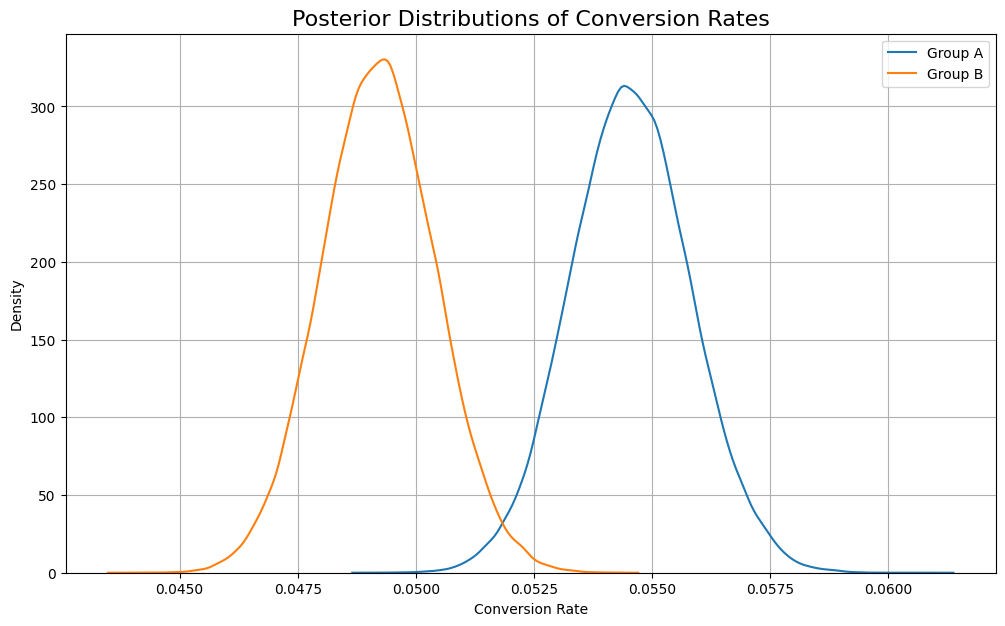



✅ Bayesian: Probability that each group is best
Probability that A is the best: 99.88%
Probability that B is the best: 0.12%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.9988,0.0012




######################################################################
📊 My car to ReadyToSell Click CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,3433,31934,10.75%
1,B,2808,32265,8.70%




✅ Z-test (2 groups)
- Z statistic: 8.7553
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 76.4214
- p-value: 0.0000



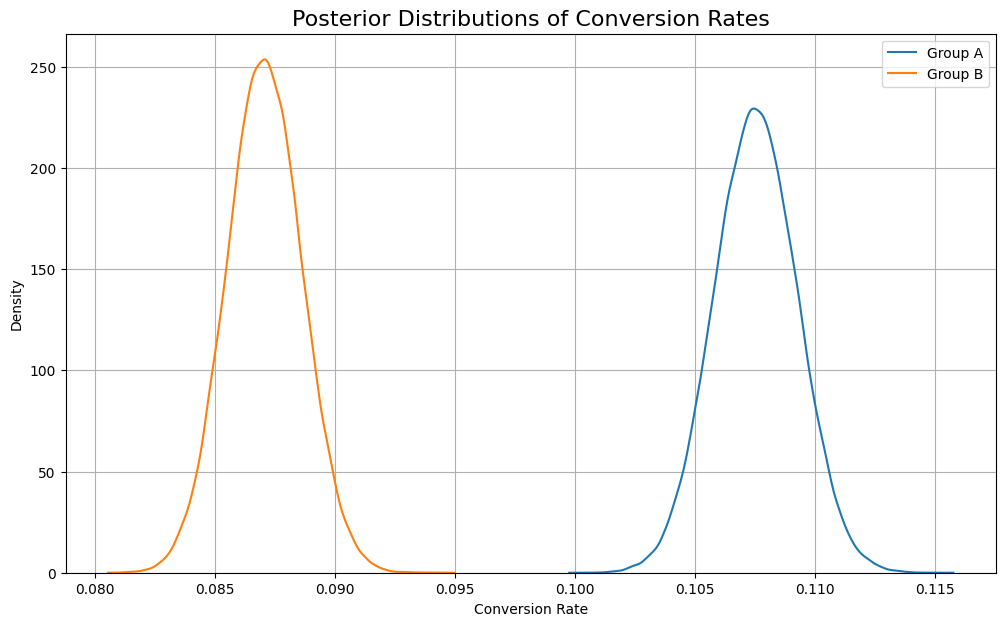



✅ Bayesian: Probability that each group is best
Probability that A is the best: 100.00%
Probability that B is the best: 0.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,1.0000,0.0000




######################################################################
📊 My car to ReadyToSell CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,2730,31934,8.55%
1,B,2213,32265,6.86%




✅ Z-test (2 groups)
- Z statistic: 8.0315
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 64.2673
- p-value: 0.0000



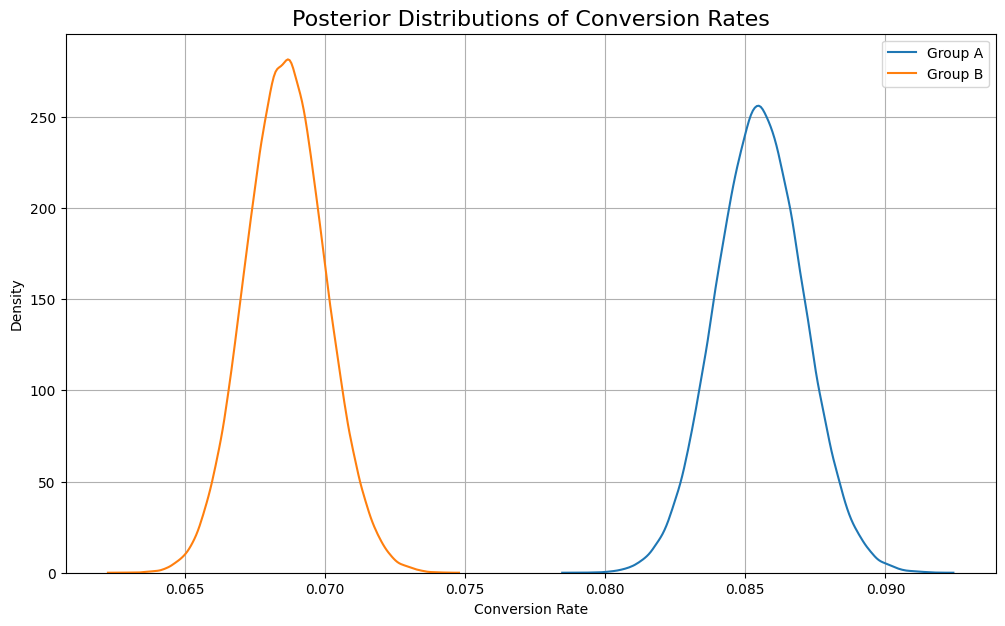



✅ Bayesian: Probability that each group is best
Probability that A is the best: 100.00%
Probability that B is the best: 0.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,1.0000,0.0000




######################################################################
📊 My car to Request a Estimate Complete CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,3377,31934,10.57%
1,B,3667,32265,11.37%




✅ Z-test (2 groups)
- Z statistic: -3.2035
- p-value: 0.0014


✅ Chi-square Test (2x2)
- Chi2 statistic: 10.1816
- p-value: 0.0014



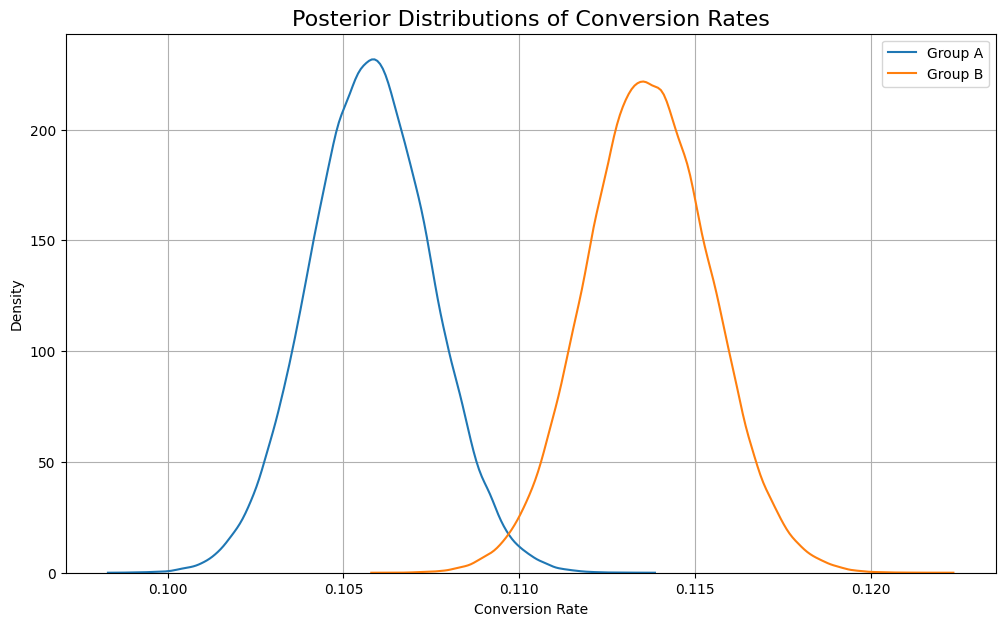



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.08%
Probability that B is the best: 99.92%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0008,0.9992




######################################################################
📊 My car to Request a Estimate Click 1 CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,12254,31934,38.37%
1,B,13832,32265,42.87%




✅ Z-test (2 groups)
- Z statistic: -11.5997
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 134.3673
- p-value: 0.0000



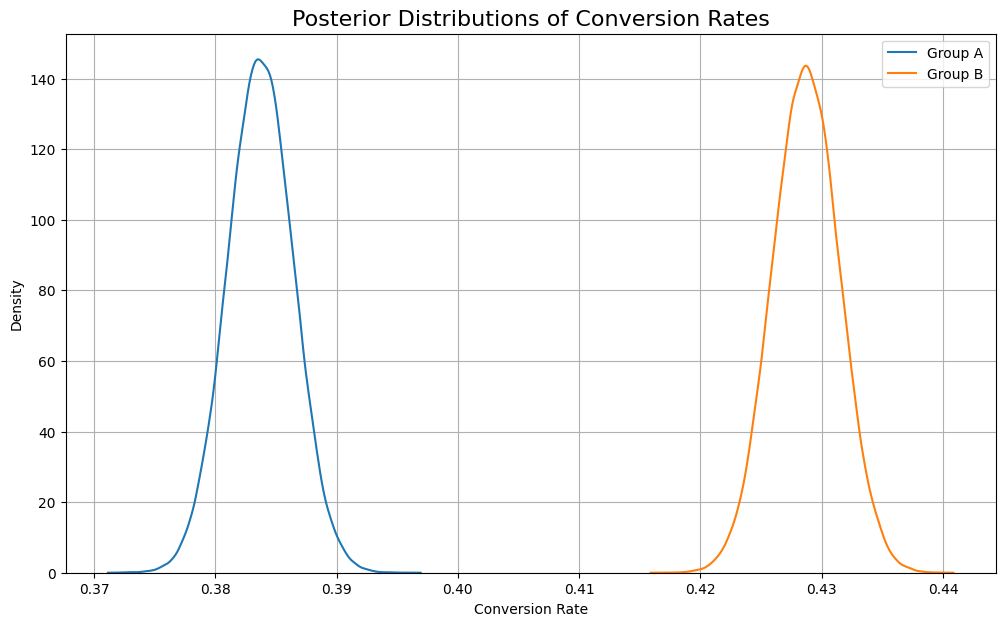



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 100.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0000,1.0000




######################################################################
📊 My car to Request a Estimate Click 2 CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,7420,31934,23.24%
1,B,8251,32265,25.57%




✅ Z-test (2 groups)
- Z statistic: -6.8929
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 47.3859
- p-value: 0.0000



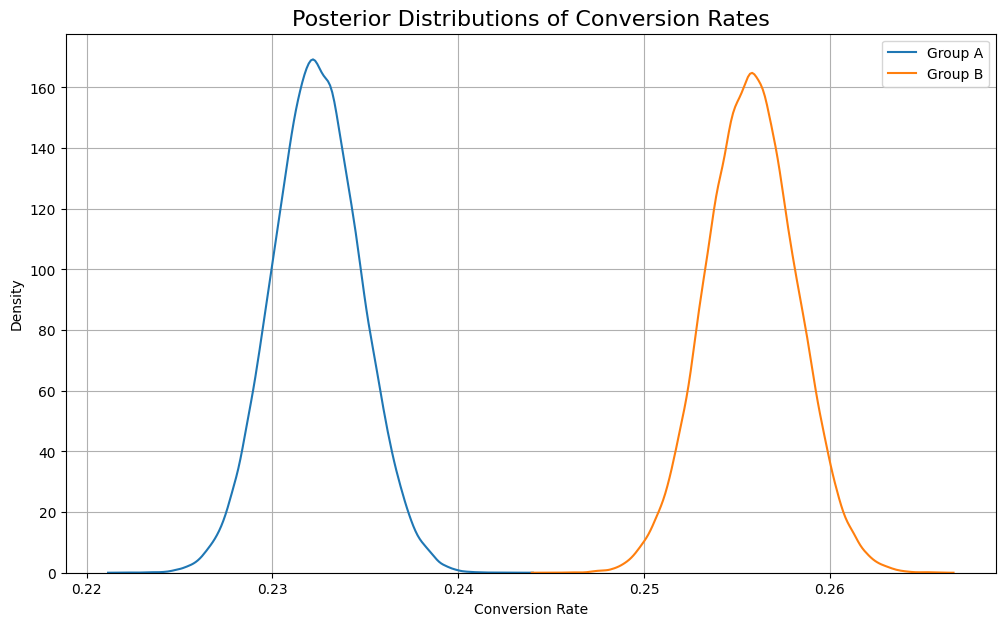



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 100.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0000,1.0000


In [13]:
# Test group 작성
groups = ['A', 'B']

# 각 이벤트 별 실험 결과 정리
CNT_TOTAL_PCID = np.array([33359, 33661])
CNT_MYCAR_HOME = np.array([33297, 33592])
CNT_MYCAR_HOME_ING = np.array([31934, 32265])
CNT_REQUEST_ESTIMATE_CLICK1 = np.array([12254, 13832])
CNT_REQUEST_ESTIMATE_CLICK2 = np.array([7420, 8251])
CNT_ESTIMATE_COMPLETE = np.array([3377, 3667])
CNT_READY_TO_SELL_CLICK = np.array([3433, 2808])
CNT_READY_TO_SELL_VIEW = np.array([2730, 2213])
CNT_READY_TO_SELL_CONFIRM = np.array([1741, 1587])
CNT_PRICE_CONFIRM = np.array([1018, 846])
CNT_PHOTO_CONFIRM = np.array([1331, 1223])
CNT_INFO_CONFIRM = np.array([687, 541])
CNT_ESTIMATE_CONFIRM = np.array([41, 39])


# AB test 3그룹 이상 인 경우 abtest_multi() 사용
# abtest_multi(groups, successes, trials, metric_name="")
# Metric 별 작성

# Success Metric
# 1. 판매준비하기 정보 입력율
abtest_auto(groups, CNT_READY_TO_SELL_CONFIRM, CNT_MYCAR_HOME_ING, metric_name="My car to ReadyToSell Confirm CVR")
# 2. 내차고 홈 - 판매준비하기 클릭율
abtest_auto(groups, CNT_READY_TO_SELL_CLICK, CNT_MYCAR_HOME_ING, metric_name="My car to ReadyToSell Click CVR")
# 3. 판매준비하기 진입율
abtest_auto(groups, CNT_READY_TO_SELL_VIEW, CNT_MYCAR_HOME_ING, metric_name="My car to ReadyToSell CVR")

# Guardrail Metric
# 4. 비교견적 신청 전환율
abtest_auto(groups, CNT_ESTIMATE_COMPLETE, CNT_MYCAR_HOME_ING, metric_name="My car to Request a Estimate Complete CVR")

# Sub Metric
# 5. 비교견적 신청 클릭율 1
abtest_auto(groups, CNT_REQUEST_ESTIMATE_CLICK1, CNT_MYCAR_HOME_ING, metric_name="My car to Request a Estimate Click 1 CVR")
# 6. 비교견적 신청 클릭율 2 (서비스 선택 후 최종 신청 클릭)
abtest_auto(groups, CNT_REQUEST_ESTIMATE_CLICK2, CNT_MYCAR_HOME_ING, metric_name="My car to Request a Estimate Click 2 CVR")
